In [1]:
import os
import fiona
import rasterio
import shapely
import numpy as np
import geopandas as gpd
from rasterio.plot import show
from matplotlib import pyplot as plt


In [2]:
path = 'D:/Programming/NightLight/images/'
path_shp = r'D:\Shapes\Shape_Brasil\BR\UF-Brasil_wgs84.shp'

rasters = [os.path.join(path + rast) for rast in os.listdir(path) if rast.endswith('.tif')]

In [3]:
# Reading raster and checking crs as bounds
image = rasterio.open(rasters[2])
tif = image.read(1)
meta = image.meta.copy()

In [113]:
# Cheking image CRS 
print('Valid CRS?', image.crs.is_valid)
print('CRS geographic?', image.crs.is_geographic)
print('CRS projected?', image.crs.is_projected)
print('EPSG code?', image.crs.is_epsg_code)
print('Linear units?', image.crs.linear_units, '\n')
print('Image bounds', image.bounds)
print('Image scale', image.scales)
print(image.crs.to_dict())
print(image.crs.to_proj4())
print(image.crs.wkt)

Valid CRS? True
CRS geographic? True
CRS projected? False
EPSG code? True
Linear units? unknown 

Image bounds BoundingBox(left=-74.00088172724648, bottom=-33.75694751500045, right=-34.78941957542937, top=5.274851579992756)
Image scale (1.0,)
{'init': 'epsg:4326'}
+init=epsg:4326
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


In [21]:
# Reading shapefile by geopandas
shape = gpd.read_file(path_shp)
print(shape.crs, image.crs)

# Unifying multipolygons to get external area
all_area = shape['geometry'].unary_union
shp_bounds = all_area.boundary.bounds

# Comparing image and shapefile info
image_bounds = image.bounds
print('Equal bounds:', image_bounds == shp_bounds)

shp_fiona = fiona.open(path_shp)
fiona_crs_wkt = shp_fiona.crs_wkt
image_crs_wkt = image.crs.wkt
print('CRS WKT equal:', fiona_crs_wkt == image_crs_wkt)

{'init': 'epsg:4326'} EPSG:4326
Equal bounds: False
CRS WKT equal: True


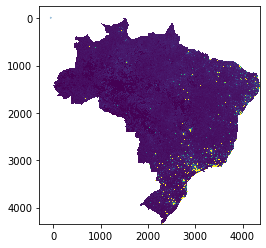

In [27]:
shape_test = shape
shape_test =  shape_test.to_crs(image.crs.to_dict())
fig, ax = plt.subplots()
img_ = plt.imshow(tif, vmin=0, vmax=5)
shape['geometry'].plot(ax=ax)


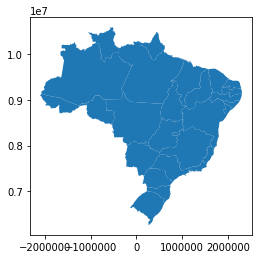

In [72]:
newimg = rasterio.open(r'C:\Users\liz\Pictures\test.tif')
#newshp = fiona.open(r'D:\Shapes\Shape_Brasil\BR\UF_Brasil_31982.shp')
newshp = gpd.read_file(r'D:\Shapes\Shape_Brasil\BR\UF_Brasil_31982.shp')

newshp = newshp.to_crs({'init': 'epsg:31982', 'proj': 'utm', 'zone': 22, 'south': True, 'ellps': 'GRS80', 'units': 'm', 'no_defs': True})
newshp.plot()

In [91]:
from rasterio import warp
with rasterio.open(r'C:\Users\liz\Pictures\test.tif', 'r+') as src:
    ras = src.read
    new_crs = rasterio.crs.CRS.from_dict(init='epsg:31982', proj='utm', zone=22, south=True, ellps='GRS80', units='m', no_defs=True)

    transform, width, height = rasterio.warp.calculate_default_transform(
                                        src.crs, new_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    print(kwargs)
    kwargs.update({
        'crs': new_crs,
        'transform': transform,
        'width': width,
        'height': height})

    with rasterio.open(r'C:\Users\liz\Pictures\test_crs.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            rasterio.warp.reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=new_crs,
                resampling=rasterio.warp.Resampling.nearest)

#https://rasterio.readthedocs.io/en/latest/topics/reproject.html

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 4504, 'height': 4662, 'count': 1, 'crs': CRS.from_epsg(31982), 'transform': Affine(990.2227281305508, 0.0, -2131588.2795,
       0.0, -990.2227281209781, 10633462.4712)}


In [97]:
img_ = rasterio.open(r'C:\Users\liz\Pictures\test_crs.tif')
tifcrs = img_.read(1)
img_.crs.to_wkt()

'PROJCS["SIRGAS 2000 / UTM zone 22S",GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4674"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","31982"]]'

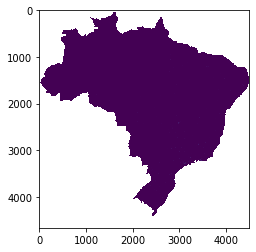

In [99]:
plt.imshow(tifcrs)

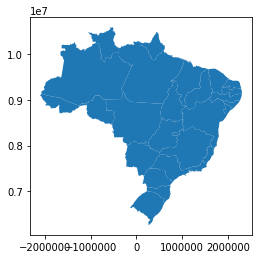

In [109]:
newshp = gpd.read_file(r'D:\Shapes\Shape_Brasil\BR\UF_Brasil_31982.shp')
dst_crs = {'init':'epsg:31982', 'proj':'utm', 'zone':'22', 'south':True, 'ellps':'GRS80', 'units':'m', 'no_defs':True}

newshp.crs = new_crs.to_wkt()
newshp.plot()

In [111]:
new_crs.to_wkt()
newshp.bounds

minx          miny          maxx          maxy
0   7.905390e+05  8.221904e+06  8.953128e+05  8.284341e+06
1   2.610862e+05  7.843883e+06  1.049742e+06  8.629466e+06
2  -6.742878e+05  8.003526e+06  5.849640e+05  9.181301e+06
3  -2.504894e+05  7.333979e+06  5.080250e+05  8.094716e+06
4  -1.403124e+05  6.262699e+06  6.278673e+05  7.002965e+06
5   1.359646e+05  7.044759e+06  7.998373e+05  7.509508e+06
6   4.951484e+05  7.456724e+06  1.697956e+06  8.415708e+06
7   9.787302e+05  7.933190e+06  2.002894e+06  9.037100e+06
8   1.905022e+06  8.686578e+06  2.114748e+06  8.920845e+06
9   1.912638e+06  8.800981e+06  2.263916e+06  8.994361e+06
10  1.884146e+06  9.203581e+06  2.295663e+06  9.450051e+06
11  1.568748e+06  9.112341e+06  2.039104e+06  9.686922e+06
12  1.050944e+06  8.785161e+06  1.681130e+06  9.693222e+06
13  5.280970e+05  8.508663e+06  1.081570e+06  9.428071e+06
14  6.868514e+04  9.863318e+06  6.249787e+05  1.049038e+07
15 -1.049273e+06  9.822263e+06 -3.802436e+05  1.059029e+07
16 -2.085484e+06  8.872990e+06 -6.766665e+04  1.025884e+07
17 -2.105463e+06  8.704682e+06 -1.232915e+06  9.147484e+06
18 -1.254544e+06  8.464763e+06 -4.574191e+05  9.099193e+06
19  1.861499e+06  9.054242e+06  2.313126e+06  9.314110e+06
20 -3.817437e+05  8.911994e+06  1.050144e+06  1.028705e+07
21  7.487410e+05  8.861427e+06  1.527136e+06  9.884022e+06
22  1.126018e+06  7.401179e+06  1.545584e+06  7.676717e+06
23  2.831027e+05  7.197255e+06  1.203672e+06  7.812765e+06
24  2.188708e+05  6.752659e+06  7.610324e+05  7.127018e+06
25  1.565399e+06  8.931191e+06  2.309505e+06  9.175854e+06
26  1.452437e+06  7.610688e+06  1.703799e+06  7.990176e+06